Pre-req: 
- Download the data:
    - Full dataset is here: https://exhibits.stanford.edu/data/catalog/zk881ps0522 
    - We want the file `joystick_track.zip`, direct link: https://stacks.stanford.edu/file/druid:zk881ps0522/joystick_track.zip
- Relevant paper: https://iopscience.iop.org/article/10.1088/1741-2560/4/3/012
- Extract the `.zip` file to the current folder, so that you have a folder named `joystick_track` with a `data` folder directly inside it.

Import libraries and load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
import scipy.io

matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


d = scipy.io.loadmat('joystick_track/data/rh_joystick.mat')

Xdata = d['data']
y_raw = d['CursorPosY']

N = Xdata.shape[0]
sample_freq = 1000
tmax = N/sample_freq
ts = np.linspace(0,tmax,N)

print(f"Data dimension: {Xdata.shape}")


Data dimension: (134360, 64)


Writing our own linear regression function!

In [2]:
def linreg(X,y):
    assert X.ndim == 2
    assert X.shape[0] == y.shape[0]
    
    C = np.dot(X.T,X)        # [P N] x [N P] = [P P]
    u = np.dot(X.T,y)        # [P N] x [N]   = [P]
    w = np.linalg.solve(C,u) # w=C^{-1}*u
    return w



Some processing:
- Adding a constant predictor to the design matrix (X)
- Discarding the first 10 seconds of the experiment
- standardizing the response variables.

In [3]:
idx = ts>=10

X = np.hstack((Xdata,np.ones((N,1))))

X = X[idx,:]
ts = ts[idx]
y = y_raw[idx]

y = (y-np.mean(y))/np.std(y)

print(X.shape)


(124360, 65)


Fit the model on ~half the data, compute the prediction and residuals:

In [4]:
w = linreg(X[ts<=60,:],y[ts<=60])

yhat = np.dot(X[ts<=60],w)
err = y[ts<=60] - yhat

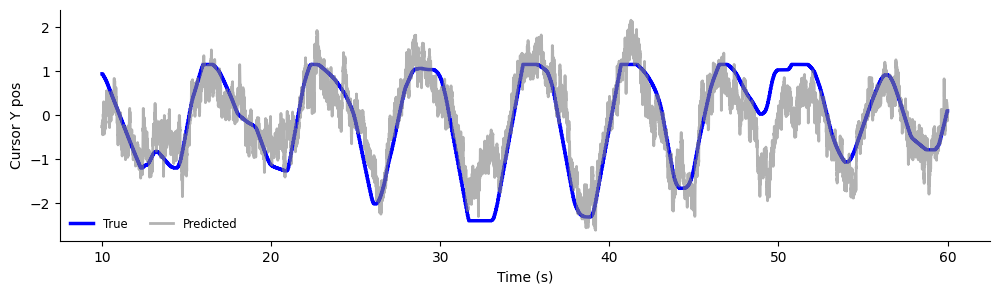

In [5]:
plt.figure(figsize=(12,3))
plt.plot(ts[ts<=60],y[ts<=60],color='blue',linewidth=2.5, label="True")
plt.plot(ts[ts<=60],yhat,color='gray',alpha=0.6, label="Predicted")
plt.xlabel("Time (s)")
plt.ylabel("Cursor Y pos")
plt.legend(ncol=2,frameon=False,loc='lower left',fontsize='small')

Text(0, 0.5, 'Density')

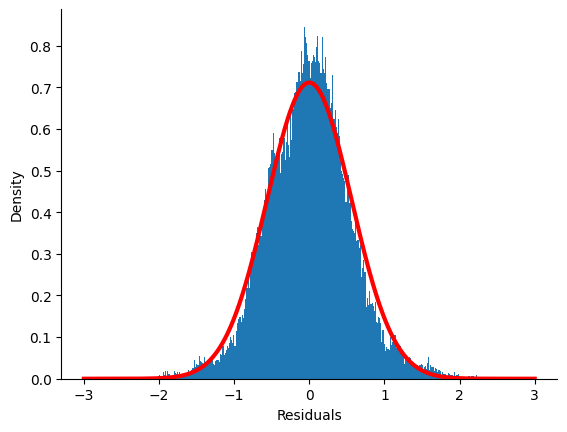

In [6]:
plt.hist(err,bins=300,density=True)
m = np.mean(err)
s = np.std(err)

xs_e = np.linspace(-3,3,2000)
gaussian_fit = (1/np.sqrt(2*np.pi*s**2))*np.exp(-0.5*((xs_e-m)/s)**2)
plt.plot(xs_e,gaussian_fit,color='red',linewidth=3)
plt.xlabel("Residuals")
plt.ylabel("Density")

Evaluate **the same model** on the rest of the data:

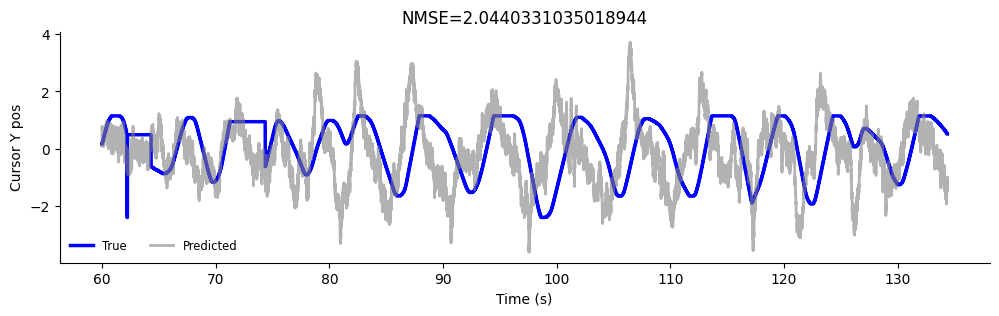

In [7]:
yhat = np.dot(X[ts>60],w)
err = y[ts>60] - yhat
nmse = np.mean(err**2)/np.var(y[ts>60])

plt.figure(figsize=(12,3))
plt.plot(ts[ts>60],y[ts>60],color='blue',linewidth=2.5, label="True")
plt.plot(ts[ts>60],yhat,color='gray',alpha=0.6, label="Predicted")
plt.title(f"NMSE={nmse}")
plt.xlabel("Time (s)")
plt.ylabel("Cursor Y pos")
plt.legend(ncol=2,frameon=False,loc='lower left',fontsize='small')

Text(0, 0.5, 'Density')

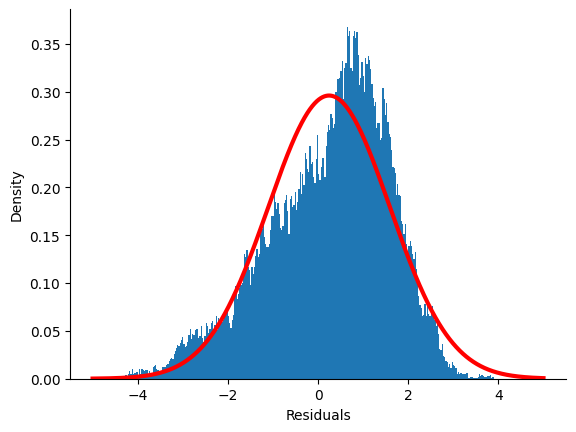

In [8]:
plt.hist(err,bins=300,density=True)
m = np.mean(err)
s = np.std(err)

xs_e = np.linspace(-5,5,2000)
gaussian_fit = (1/np.sqrt(2*np.pi*s**2))*np.exp(-0.5*((xs_e-m)/s)**2)
plt.plot(xs_e,gaussian_fit,color='red',linewidth=3)
plt.xlabel("Residuals")
plt.ylabel("Density")

Things to try out next:
- Different train/test split: instead of training on first half of the data, train on a _random_ half of the timepoints. Are the results different? why?
- Compare the results to those achieved by `sklearn.linear_model.LinearRegression`. Remember that the `sklearn` module adds intercept by default.
- Repeat with a different target (Cursor X pos, different subject, ...)
- Repeat the analysis with a regularized model (e.g., Ridge regression)
- Can we make sense of the vector of coefficients (`w`)?